In [13]:
import sys, os

from pyparsing import C
sys.path.append(os.path.abspath("./../feedback-grape"))
sys.path.append(os.path.abspath("./../"))

from feedback_grape.fgrape import evaluate_on_longer_time
from feedback_grape.utils.tensor import tensor
from feedback_grape.utils.fidelity import ket2dm, fidelity
from feedback_grape.utils.states import basis
from helpers import (
    init_fgrape_protocol,
    init_fgrape_protocol_wo_decay,
    test_implementations,
)
from tqdm import tqdm
import jax, re, json
import numpy as np

jax.config.update("jax_enable_x64", True)

# Physical parameters
gamma_p_global = None # None = Take value from filename
gamma_m_global = None # None = Take value from filename
evaluation_state_type = None # None = Take value from filename

# System parameters
target   = "000"
syndrome = "100"

C_target = ket2dm( ( 
    tensor(basis(2,0), basis(2,0), basis(2,0))
    + tensor(basis(2,1), basis(2,1), basis(2,1))) /np.sqrt(2)  # (|000> + |111>)/sqrt(2
)
U_0 = ket2dm( ( 
    tensor(basis(2,1), basis(2,0), basis(2,0))
    + tensor(basis(2,0), basis(2,1), basis(2,1))) /np.sqrt(2)  # (|100> + |011>)/sqrt(2
)

# Evaluation parameters
evaluation_time_steps = 8 # Number of time steps for evaluation
batch_size = 2048 # Number of random states to evaluate in parallel
initial_measurement_history_length = 2
tolerance = 0.25 # matrix equality tolerance

dir_ = "./04_results/"
file = "./models/lut_t=3_l=2_w=111_Nqubits=3_Nmeas=2_gammap=0.0001_gammam=0.05336699231206307_rhot=bloch_rhoe=bloch_s=0.json"

print("Opening file...")
with open(os.path.join(dir_, file)) as f:
    model = json.load(f)
print("Done.")

Opening file...
Done.


In [14]:
def evaluate_model(filename, model, initial_measurement_history):
    N_qubits = int(re.search(r"Nqubits=(\d+)_", filename).group(1))
    N_meas = int(re.search(r"Nmeas=(\d+)_", filename).group(1))
    if gamma_p_global is None:
        gamma_p = float(re.search(r"gammap=([\d.]+)_", filename).group(1))
    else:
        gamma_p = gamma_p_global
    if gamma_m_global is None:
        gamma_m = float(re.search(r"gammam=([\d.]+)_", filename).group(1))
    else:
        gamma_m = gamma_m_global

    system_params = init_fgrape_protocol_wo_decay(
        jax.random.PRNGKey(0),
        N_qubits,
        N_meas,
        gamma_p,
        gamma_m,
    )

    eval_result = evaluate_on_longer_time(
        U_0 = U_0,
        C_target = C_target,
        system_params = system_params,
        optimized_trainable_parameters = model["optimized_trainable_parameters"],
        num_time_steps = evaluation_time_steps,
        evo_type = "density",
        goal = "fidelity",
        eval_batch_size = batch_size,
        mode = "lookup",
        initial_measurement_history = initial_measurement_history,
    )

    return eval_result.final_state

final_state_set = []
final_state_counts = []
final_state_fidelities = []

initial_measurement_history = [-1]*(initial_measurement_history_length - 1) + [-3]
num_histories = 2**initial_measurement_history_length
for _ in tqdm(range(num_histories)):
    initial_measurement_history[-1] += 2
    for i in range(len(initial_measurement_history)-1, 0, -1):
        if initial_measurement_history[i] > 1:
            initial_measurement_history[i] = -1
            initial_measurement_history[i-1] += 2

    rho_finals = evaluate_model(file, model, initial_measurement_history)
    for j, rho_final in enumerate(rho_finals):
        idx = -1
        for i, existing_rho in enumerate(final_state_set):
            if np.allclose(rho_final, existing_rho, atol=tolerance):
                idx = i
                break
        if idx == -1:
            final_state_set.append(rho_final)
            final_state_counts.append(1)
        else:
            final_state_counts[idx] += 1

idx = np.argsort(final_state_counts)[::-1]
final_state_set = [final_state_set[i] for i in idx]
final_state_counts = [final_state_counts[i] for i in idx]
tot = sum(final_state_counts)

for rho_final in final_state_set:
    fid = fidelity(C_target=C_target, U_final=rho_final, evo_type="density")
    final_state_fidelities.append(fid)

print("\ntotal runs:", tot)
print("Distinct final states found:", len(final_state_set))
print("Final state distribution:")
for i, count in enumerate(final_state_counts):
    print(f"Count: {count} ({count/tot*100:.2f}%)")

100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


total runs: 8192
Distinct final states found: 5
Final state distribution:
Count: 7388 (90.19%)
Count: 780 (9.52%)
Count: 12 (0.15%)
Count: 10 (0.12%)
Count: 2 (0.02%)


/var/folders/xf/w68q44ts63nb4v2nl66dh3yr0000gn/T/ipykernel_15737/468648626.py:49: UserWarning: Adding colorbar to a different Figure <Figure size 400x400 with 4 Axes> than <Figure size 200x200 with 2 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax, orientation='vertical')


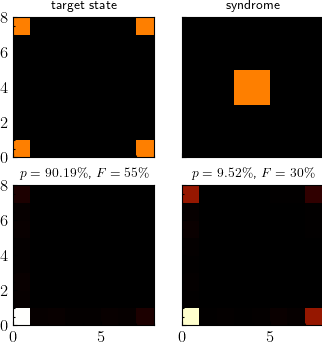

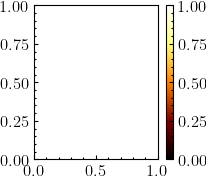

In [15]:
from cProfile import label
import matplotlib
from matplotlib import pyplot as plt
from plot_helpers import * # to apply rcparams
matplotlib.rcParams.update({'font.size': 8})

cutoff = 0.01 # cutoff for plotting (1%)
n_plots = sum(np.array(final_state_counts)/tot >= cutoff) + 2
cols = int(np.sqrt(n_plots))
rows = int(np.ceil(n_plots / cols))
fig, axs = plt.subplots(rows, cols, figsize=(cols*2,rows*2), sharex=True, sharey=True)
axs = axs.flatten()

axs[0].set_title("target state")
axs[0].pcolor(
    np.abs(C_target),
    cmap='afmhot',
    vmin = 0,
    vmax = 1,
)

axs[1].set_title("syndrome")
axs[1].pcolor(
    np.abs(U_0),
    cmap='afmhot',
    vmin = 0,
    vmax = 1,
)

for i in range(0, len(final_state_set)):
    occurrence = final_state_counts[i]/tot
    if occurrence < cutoff:
        break
    fid = final_state_fidelities[i]
    axs[i+2].set_title(f"$p={occurrence*100:.2f}\\%$, $F={int(fid*100)}\\%$")
    im = axs[i+2].pcolor(
        np.abs(final_state_set[i]),
        cmap='afmhot',
        vmin = 0,
        vmax = 1,
    )

for ax in axs[n_plots:]:
    ax.axis('off')

fig.savefig(dir_ + f"single_model_evaluation/target={target}_syndrome={syndrome}_t={evaluation_time_steps}.svg", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(2,2))
cbar = fig.colorbar(im, ax=ax, orientation='vertical')
fig.savefig(dir_ + f"single_model_evaluation/colorbar.svg", bbox_inches='tight')